# On the properties of variational approximations of Gibbs posteriors

In [1]:
import numpy as np 
from numpy.linalg import eigvals
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
np.random.seed(2025)

 The Gibbs posterior (or pseudo-posterior $\hat{\rho _{\lambda}}$) is defined for all $\lambda > 0$ as : 
 
 $$\hat{\rho _{\lambda}} (\theta) \propto \exp\left(-\lambda r_n (\theta)\right) \pi(\theta), $$

where:

- $r_n( \theta )$ is an empirical measure of risk

- $\pi(\theta)$ is the prior.

In [2]:
def risk(w, X, y):
    """Loss function: Quadratic loss with L2 regularization."""
    predictions = X @ w
    loss = np.mean((predictions - y) ** 2)
    reg = 0.5 * np.sum(w ** 2)  # L2 regularization
    return loss + reg

def gibbs_posterior(w, X, y, lambda_reg):
    return np.exp(
        -lambda_reg * risk(w, X, y)
        )

def variational_approximation(X, y, lambda_reg):
    def objective(w):
        return risk(w, X, y) + lambda_reg * np.sum(w ** 2)  
    w0 = np.zeros(X.shape[1]) 
    result = minimize(objective, w0, method = 'L-BFGS-B')
    return result.x

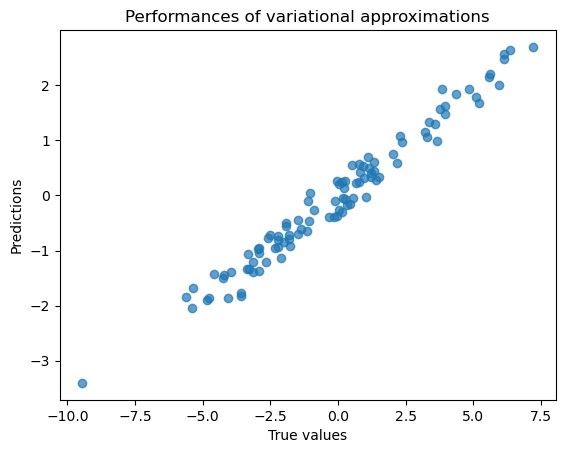

In [3]:
n, d = 100, 10
X = np.random.randn(n, d)
true_w = np.random.randn(d)
y = X @ true_w + 0.1 * np.random.randn(n)
lambda_reg = 1.0

w_gibbs = variational_approximation(X, y, lambda_reg)

# Comparison
predictions = X @ w_gibbs
plt.scatter(y, predictions, alpha = 0.7)
#plt.xscale("log")   
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title("Performances of variational approximations")
plt.show()


# Section 5 : Application to classification

In all this section, we assume that $ Y = \{0, 1\} $ and we consider linear classification: $ \Theta = X = \mathbb{R}^d $, $ f_\theta(x) = \mathbf{1}_{\langle \theta, x \rangle \geq 0} $. We put 

$$r_n(\theta) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}\{f_\theta(X_i) \neq Y_i\}, \quad R(\theta) = \mathbb{P}(Y \neq f_\theta(X)), $$

and assume that the $(X_i, Y_i)_{i=1}^n $ are i.i.d.
In this setting, it is well-known that the Hoeffding assumption always holds. That's to say:


## Hoeffding assumption

We say that a **Hoeffding assumption** is satisfied for prior $ \pi $ when there is a function $ f $ and an interval $ I \subset \mathbb{R}_+^* $ such that, for any $ \lambda \in I $, for any $ \theta \in \Theta $,

$$ \frac{\pi \left( \mathbb{E} \exp \{ \lambda [R(\theta) - r_n(\theta)] \} \right)}{\pi \left( \mathbb{E} \exp \{ \lambda [r_n(\theta) - R(\theta)] \} \right)} 
\leq \exp \big[ f(\lambda, n) \big]. \tag{1} $$

Here, Hoeffding assumption is satisfied with $f(\lambda, n) = \frac{\lambda^2}{2n}$.

## Bernstein assumption

We say that a Bernstein assumption is satisfied for prior $\pi$ when there is a function $g$ and an interval $I \subset \mathbb{R}_+^*$ such that, for any $\lambda \in I$, for any $\theta \in \Theta$,
$$
\frac{\pi \left( \mathbb{E} \exp \left\{ \lambda [R(\theta) - R^*] - \lambda [r_n(\theta) - r_n^*] \right\} \right)}
{\pi \left( \mathbb{E} \exp \left\{ \lambda [r_n(\theta) - r_n^*] - \lambda [R(\theta) - R^*] \right\} \right)} 
\leq \pi \exp \big[ (g(\lambda, n))  [R(\theta) - R^*] \big].
\tag{2}
$$

Assume that **Mammen and Tsybakov’s** margin assumption is satisfied: i.e., there is a constant $C$ such that
$$
\mathbb{E} \left[ \big( \mathbf{1}_{f_\theta(X) \neq Y} - \mathbf{1}_{f_{\theta^*}(X) \neq Y} \big)^2 \right] 
\leq C \big[ R(\theta) - R(\theta^*) \big].
$$
Then Bernstein assumption is satisfied with 
$$
g(\lambda, n) = \frac{C \lambda^2}{2n - \lambda}.
$$

## The prior 

Gaussian prior : $ \pi = \mathcal{N}_d (0, v^2 \text{I}_d )$.

## Three sets of Variational Gaussian approximations:  
Consider the three following Gaussian families 
$$
\mathcal{F}_1 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in \mathbb{R}_+^* \},
$$
$$
\mathcal{F}_2 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in (\mathbb{R}_+^*)^d \},
$$
$$
\mathcal{F}_3 = \{ \Phi_{m, \Sigma} \mid m \in \mathbb{R}^d, \Sigma \in \mathcal{S}_d^+ \},
$$
where $\Phi_{m, \sigma^2}$ is a Gaussian distribution $\mathcal{N}_d(m, \sigma^2 I_d)$, $\Phi_{m, \sigma^2}$ is $\mathcal{N}_d(m, \text{diag}(\sigma^2))$, and $\Phi_{m, \Sigma}$ is $\mathcal{N}_d(m, \Sigma)$. 

Obviously, $\mathcal{F}_1 \subset \mathcal{F}_2 \subset \mathcal{F}_3 \subset \mathcal{M}_1^+(\Theta)$, and
$$
B_\lambda(\mathcal{M}_1^+(\Theta)) \leq B_\lambda(\mathcal{F}_3) \leq B_\lambda(\mathcal{F}_2) \leq B_\lambda(\mathcal{F}_1).
$$


In [4]:
def L_F2(m, sigma2, X, y, lmbda, nu):
    """ 
    Variational lower bound for mean field family, as defined page 11 (section 5.4)
    Evaluated for given m, sigma2
    """
    n, d = X.shape

    first_sum = 0
    for i in range(n):
        first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
    second_sum = 0
    for k in range(d):
        second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)
        
    return -(lmbda/n)*first_sum - (m.T @ m)/(2*nu) + 0.5*second_sum

def L_F3(m, Sigma, X, y, lmbda, nu):
    """ 
    Variational lower bound for full covariance family, as defined page 11 (section 5.4)
    Evaluated for given m, Sigma
    """
    n, d = X.shape

    first_sum = 0
    for i in range(n):
        first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ Sigma @ X[i].T ) ) )
        
    return -(lmbda/n)*first_sum - (m.T @ m)/(2*nu) + 0.5*(np.log(np.linalg.det(Sigma)) - (1/nu)*np.trace(Sigma))

def vec_to_lower_triangular(x, n):
    """Convert vector to lower triangular matrix."""
    L = np.zeros((n, n))
    idx = 0
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                L[i, j] = np.exp(x[idx])  # Diagonal elements are exp(x)
            else:
                L[i, j] = x[idx]  # Off-diagonal elements unchanged
            idx += 1
    return L

def lower_triangular_to_vec(L):
    """Convert lower triangular matrix to vector."""
    n = L.shape[0]
    x = []
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                x.append(np.log(L[i, j]))  # Log of diagonal elements
            else:
                x.append(L[i, j])
    return np.array(x)

def logCholesky_L_F3(m, L, X, y, lmbda, nu): # L is a vector
    """ 
    Variational lower bound for full covariance family, as defined page 11 (section 5.4)
    Evaluated for given m, L, with L the vector of the log-Cholesky parametrization
    """
    n, d = X.shape
    L = vec_to_lower_triangular(L, d)
    Sigma = L @ L.T  # Reconstruct positive definite matrix

    return L_F3(m, Sigma, X, y, lmbda, nu)

In [5]:
class DeterministicAnnealing():
    def __init__(self, temperatures, patience, X, y, nu=None, verbose=False):
        self.temperatures = temperatures
        self.patience = patience
        self.verbose = verbose
        self.X = X # X_train et X_test ?
        self.n, self.d = X.shape
        self.y = y
        if not nu:
            self.nu = self.d / (self.d + 2 + 2*self.d/self.n)
        else:
            self.nu = nu

    # Peut-être faire un train et un test ou une cross validation pour calculer l'empirical bound de manière plus réaliste ???
    # Faire par cross validation pour choisir lambda plutôt que par l'empirical bound donnerait peut-être de meilleurs résultats
    
    def compute_empirical_bound(self, m, sigma2, lmbda, epsilon, n_examples=1000):
        # First get an approximation of the integrated risk
        ypred = []
        ytrue = []
        for _ in range(n_examples):
            i = np.random.randint(0, self.n)
            beta = stats.multivariate_normal(mean=m, cov=np.diag(sigma2)).rvs()
            ypred.append(0.5 * (np.sign(self.X[i] @ beta) + 1))
            ytrue.append(self.y[i])
        ypred = np.array(ypred)
        ytrue = np.array(ytrue)
        empirical_risk = np.mean(ypred != ytrue)
        # print(empirical_risk)

        # Compute the numerator of the last term
        numerator = np.sum([0.5*np.log(self.nu**2 / sigma2[i]**2) + sigma2[i]**2 / self.nu**2 for i in range(self.d)]) + m@m / self.nu**2 - d/2 + np.log(1/epsilon)
        return empirical_risk + lmbda/(2*self.n) + (1/lmbda)*numerator

    def run_F2(self):
        # Init
        m_t = np.zeros(self.d)
        sigma2_t = self.nu*np.ones(self.d)
        params_t = np.concatenate([m_t, sigma2_t], axis=0)
        value_t = L_F2(params_t[:self.d], params_t[self.d:], self.X, self.y, 0, self.nu) # max L_F2    
        # print(value_t)
        # empirical_bound_t = self.compute_empirical_bound(m_t, sigma2_t, 0, 0.05)
        # print(empirical_bound_t)
        empirical_bound_star = np.inf

        # Loop
        p = 0 # patience counter
        for ix, lmbda_t in enumerate(self.temperatures):
            if self.verbose:
                print(lmbda_t)
            # a)
            params_prev = params_t.copy()
            objective_t = lambda params: - L_F2(params[:self.d], params[self.d:], self.X, self.y, lmbda_t, self.nu)
            bounds = [(None, None)]*self.d + [(0, None)]*self.d
            results = minimize(
                objective_t, 
                params_prev, 
                method='L-BFGS-B',
                bounds = bounds
            )
            params_t = results.x
            # value_t = - results.fun
            # print(value_t)
            m_t = params_t[:self.d]
            sigma2_t = params_t[self.d:]
            empirical_bound_t = self.compute_empirical_bound(m_t, sigma2_t, lmbda_t, 0.05)
            if self.verbose:
                print(empirical_bound_t)
            # b)
            if empirical_bound_t > empirical_bound_star:
                p += 1
                if p == self.patience:
                    return m_star, sigma2_star, empirical_bound_star, lmbda_star
            else:
                p = 0
                m_star, sigma2_star, empirical_bound_star, lmbda_star = m_t.copy(), sigma2_t.copy(), empirical_bound_t, lmbda_t
        return m_t, sigma2_t, empirical_bound_t, lmbda_t

    def run_F3(self, lmbda_star_F2):
        # Init
        m_t = np.zeros(self.d)
        L_t = np.sqrt(self.nu)*np.eye(self.d)
        # print(self.nu)
        logCholesky_L_t = lower_triangular_to_vec(L_t)
        # print(L_t)
        # print(vec_to_lower_triangular(logCholesky_L_t, self.d))
        Sigma_t = L_t @ L_t.T
        # print(Sigma_t) # vérifier qu'on retrouve le bon
        params_t = np.concatenate([m_t, logCholesky_L_t], axis=0)
        value_t = logCholesky_L_F3(m_t, logCholesky_L_t, self.X, self.y, 0, self.nu)
        empirical_bound_t = np.inf      

        # Loop
        p = 0
        for ix, lmbda_t in enumerate(self.temperatures):
            if self.verbose:
                print(lmbda_t)
            # a)
            params_prev = params_t.copy()
            # il faut faire la reparamétrisatiion
            objective_t = lambda params: - logCholesky_L_F3(params[:self.d], params[self.d:], self.X, self.y, lmbda_t, self.nu)
            result = minimize(
                fun=objective_t,
                x0=params_prev,
                method='L-BFGS-B'
            )
            params_t = result.x
            # value_t = - result.fun
            m_t = params_t[:self.d]
            L_t = vec_to_lower_triangular(params_t[self.d:], self.d)
            Sigma_t = L_t @ L_t.T
             # b)
            if lmbda_t == lmbda_star_F2:
                return m_t, Sigma_t

In [6]:
# sur un dataset généré

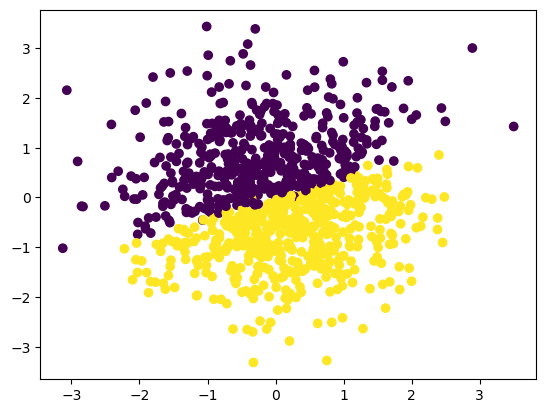

In [7]:
n, d = 1000, 2
X = np.random.randn(n, d)
true_w = np.random.randn(d)
y = 0.5 * (np.sign(X @ true_w + 0.1 * np.random.randn(n)) + 1)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [8]:
temperatures = list(range(10, 500, 10))
DA = DeterministicAnnealing(temperatures=temperatures, patience=5, X=X, y=y, verbose=True)
m_F2, sigma2_F2, _, lmbda_star_F2 = DA.run_F2()
m_F3, Sigma_F3 = DA.run_F3(lmbda_star_F2)

10
0.8066549649947355
20
0.5087384670613884
30


/tmp/ipykernel_38838/4038806100.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/tmp/ipykernel_38838/4038806100.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/tmp/ipykernel_38838/4038806100.py:13: RuntimeWarning: divide by zero encountered in log
  second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)


0.3821589780409256
40
0.3230730795497953
50
0.30405846363983624
60
0.2547153863665302
70


/opt/conda/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


0.24793159806675025
80
0.23481514830840647
90
0.21616902071858354
100
0.21165211864672517
110
0.21041101695156833
120
0.21187676553893764
130
0.205590125789279
140
0.20865187487422912
150
0.20754174988261387
160
0.1941953905149505
170
0.20847801460230636
180
0.19628479156884487
190
0.19853296043364252
200
0.20778257040629589
210
0.20417207195625392
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


100%|██████████| 1000/1000 [00:00<00:00, 3168.23it/s]


0.032


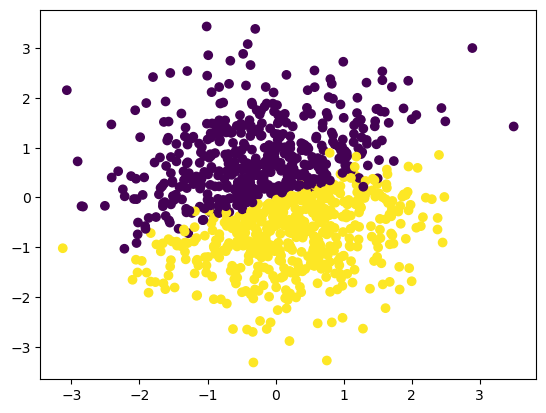

In [9]:
ypred = []
for i in tqdm(range(len(X))):
    beta = stats.multivariate_normal(mean=m_F2, cov=np.diag(sigma2_F2)).rvs()
    ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
print(np.mean(ypred != y)) # Missclassification rate
plt.scatter(X[:, 0], X[:, 1], c=ypred)
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 3350.17it/s]


0.028


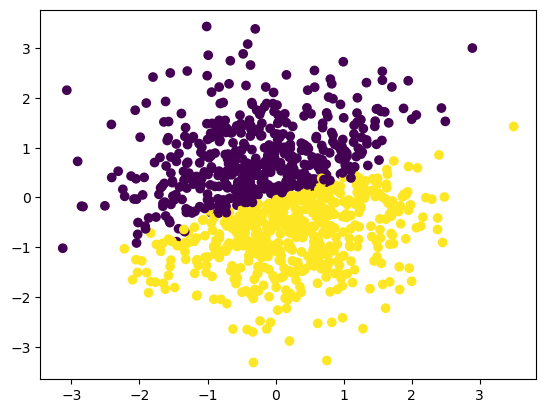

In [10]:
ypred = []
for i in tqdm(range(len(X))):
    beta = stats.multivariate_normal(mean=m_F3, cov=Sigma_F3).rvs()
    ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
print(np.mean(ypred != y)) # Missclassification rate
plt.scatter(X[:, 0], X[:, 1], c=ypred)
plt.show()

In [11]:
def L_hinge(m, sigma, X, y, lmbda, nu): # lower bound to be maximized
    n, d = X.shape

    # print(y)
    # print( np.tile(y, (d, 1)) )

    Gamma =np.tile(y, (d, 1)).T * X
    Gamma_norms = [np.sqrt(Gamma[i]@Gamma[i]) for i in range(n)]
    
    first_sum = 0
    second_sum = 0
    for i in range(n):
        first_sum += (1 - Gamma[i]@m) * stats.norm.cdf( (1 - Gamma[i]@m) / (sigma * Gamma_norms[i]) )
        second_sum += sigma * Gamma_norms[i] * stats.norm.pdf ( (1 - Gamma[i]@m) / (sigma * Gamma_norms[i]) )
        
    return -(lmbda/n)*( first_sum + second_sum ) - m@m / (2*nu) + 0.5*d*(np.log(sigma**2) - nu/sigma**2)


In [12]:
class HingeLoss():
    def __init__(self, X, y):
        self.X = X
        self.y = 2*y - 1 # rescaler sur -1, 1
        self.n, self.d = X.shape
        self.sigma = 1/np.sqrt(self.n)
        self.nu = 1/np.sqrt(self.d)
        
    def cross_validate(self, lmbda, n_examples_test=1000):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        miss = []
        for (train_index, test_index) in skf.split(self.X, self.y):
            X_train, y_train = self.X[train_index], self.y[train_index]
            # minimiser L_hinge avec le lambda considéré
            objective = lambda m: - L_hinge(m, self.sigma, X_train, y_train, lmbda, self.nu)
            # print(objective(np.zeros(self.d)))
            x0 = np.zeros(self.d)
            result = minimize(
                fun=objective,
                x0=x0,
                method='L-BFGS-B'
            )
            m_star = result.x
            # regarder l'accuracy sur le test set
            ypred = []
            ytrue = []
            for _ in range(n_examples_test):
                i = np.random.choice(test_index)
                beta = stats.multivariate_normal(mean=m_star, cov=np.diag(np.ones(self.d)*self.sigma**2)).rvs()
                ypred.append(np.sign(self.X[i] @ beta))
                ytrue.append(self.y[i])
            ypred = np.array(ypred)
            ytrue = np.array(ytrue)

            miss.append(np.mean(ypred != ytrue))
            # print(miss)
        return np.mean(miss)
            
    def run(self, lmbdas):
        miss = {}
        for lmbda in lmbdas:
            print(lmbda)
            miss[lmbda] = self.cross_validate(lmbda)
        self.lmbda_star = lmbdas[np.argmin(list(miss.values()))]
        return miss

    def fit_with_lmbda_star(self):
        objective = lambda m: - L_hinge(m, self.sigma, self.X, self.y, self.lmbda_star, self.nu)
        # print(objective(np.zeros(self.d)))
        x0 = np.zeros(self.d)
        result = minimize(
            fun=objective,
            x0=x0,
            method='L-BFGS-B'
        )
        return result.x
        

In [13]:
# sur un dataset généré

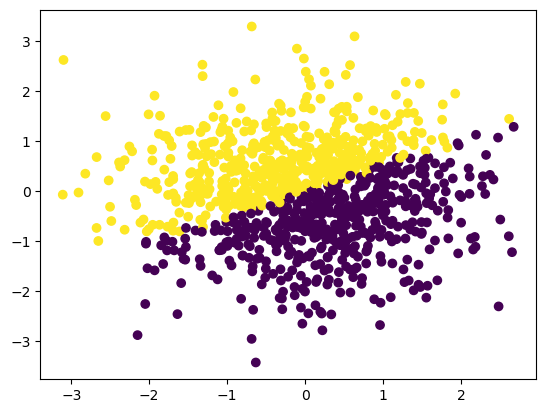

In [14]:
n, d = 1000, 2
X = np.random.randn(n, d)
true_w = np.random.randn(d)
y = 0.5 * (np.sign(X @ true_w + 0.1 * np.random.randn(n)) + 1)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [15]:
HL = HingeLoss(X=X, y=y)
miss = HL.run(lmbdas = np.logspace(0, 5, 12))
print(miss)

1.0
2.8480358684358014
8.11130830789687
23.101297000831593
65.79332246575679
187.3817422860383
533.6699231206308
1519.9110829529332
4328.761281083057
12328.467394420659
35111.917342151275
100000.0
{np.float64(1.0): np.float64(0.029000000000000005), np.float64(2.8480358684358014): np.float64(0.0176), np.float64(8.11130830789687): np.float64(0.0172), np.float64(23.101297000831593): np.float64(0.018399999999999996), np.float64(65.79332246575679): np.float64(0.014199999999999999), np.float64(187.3817422860383): np.float64(0.0188), np.float64(533.6699231206308): np.float64(0.0196), np.float64(1519.9110829529332): np.float64(0.0166), np.float64(4328.761281083057): np.float64(0.0164), np.float64(12328.467394420659): np.float64(0.016999999999999998), np.float64(35111.917342151275): np.float64(0.0186), np.float64(100000.0): np.float64(0.0194)}


In [16]:
print(HL.lmbda_star)
print(miss[HL.lmbda_star])

65.79332246575679
0.014199999999999999


In [17]:
print(HL.lmbda_star)
m_hinge = HL.fit_with_lmbda_star()

65.79332246575679


100%|██████████| 1000/1000 [00:00<00:00, 3518.53it/s]


0.018


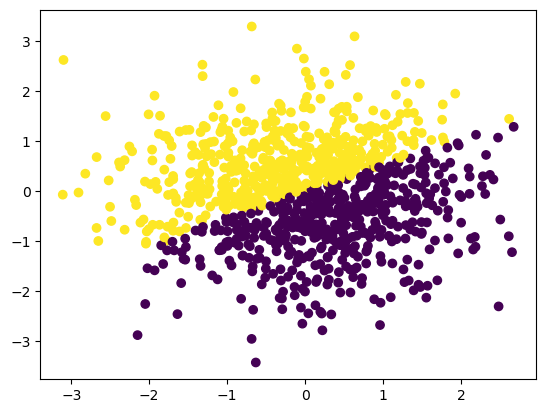

In [18]:
ypred = []
for i in tqdm(range(len(X))):
    beta = stats.multivariate_normal(mean=m_hinge, cov=np.diag(np.ones(HL.d)*HL.sigma**2)).rvs()
    ypred.append(np.sign(X[i] @ beta))
print(np.mean(ypred != 2*y-1)) # Missclassification rate
plt.scatter(X[:, 0], X[:, 1], c=ypred)
plt.show()

# Application sur des jeux de données

In [19]:
DATASET = ['pima-indians-diabetes',
           #'credit',
           'credit-g',
           #'dna', # more than 2 classes
           #'spectf', # very long to compute
           #'glass', # more than 2 classes
           #'indian',
           'breast-cancer']

DATASET_DOWNLOAD = [fetch_openml(name = dataset, 
                                 version=1) 
                                 for dataset in DATASET]

In [20]:
def preprocess_data(X):
    label_encoder = LabelEncoder()
    for col in X.columns:  # If X is a pandas dataframe
        if X[col].dtype == 'category':  # Only encode string columns
            X[col] = label_encoder.fit_transform(X[col])
    return X

## Gibbs posteriors with misclassification rate loss

In [21]:
misclassification_rates_F2 = []
misclassification_rates_F3 = []
for i, dataset in enumerate(DATASET_DOWNLOAD):
    print('='*100)
    print(dataset.details['name'])
    print('='*100, end='\n')
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X).to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = pd.factorize(y)[0]
    
    temperatures = list(range(10, 500, 10))
    DA = DeterministicAnnealing(temperatures=temperatures, patience=5, X=X, y=y, verbose=True)
    m_F2, sigma2_F2, empirical_bound_star, lmbda_star_F2 = DA.run_F2()
    m_F3, Sigma_F3 = DA.run_F3(lmbda_star_F2)

    print(f'Empirical bound for the optimal lambda={lmbda_star_F2} : {empirical_bound_star}')

    mis_rates = []
    for _ in tqdm(range(10)):
        ypred = []
        for i in range(len(X)):
            beta = stats.multivariate_normal(mean=m_F2, cov=np.diag(sigma2_F2)).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
        mis_rate = (ypred != y).mean()
        mis_rates.append(mis_rate)
    print(f'Average misclassification rate, mean field: {np.mean(mis_rates)}')
    misclassification_rates_F2.append(np.mean(mis_rates))

    mis_rates = []
    for _ in tqdm(range(10)):
        ypred = []
        for i in range(len(X)):
            beta = stats.multivariate_normal(mean=m_F3, cov=Sigma_F3).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
        mis_rate = (ypred != y).mean()
        mis_rates.append(mis_rate)
    
    print(f'Average misclassification rate, full covariance: {np.mean(mis_rates)}')
    misclassification_rates_F3.append(np.mean(mis_rates))
    
    print('\n'*3)
        

Pima-Indians-Diabetes
10
1.474870195214939
20
0.9384916625136195
30
0.7610927609294484
40
0.6390115568112358
50
0.6318273563971798
60
0.5809096409311204
70
0.5676973801991836
80
0.530950036096755
90
0.5178818740799527
100
0.5444312162982015
110
0.5159325097588368
120
0.48995495213063633
130
0.5112087870187938
140
0.5324959976902581
150
0.5016684846475065
160
0.5235943476522925
170
0.5001384325258947
10
20
30
40
50
60
70
80
90
100
110
120
Empirical bound for the optimal lambda=120 : 0.48995495213063633


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Average misclassification rate, mean field: 0.3013020833333334


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]
/tmp/ipykernel_38838/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/tmp/ipykernel_38838/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/tmp/ipykernel_38838/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Average misclassification rate, full covariance: 0.30625




credit-g
10
2.690014215765747
20
1.5987499943509607
30
1.244818085373121
40
1.04035889846384
50
0.9094061919254901
60
0.829282637480976
70
0.8262483786178543
80
0.7544147008508149
90
0.6954919668193633
110
0.7120586569034941
120
0.7049481217325292
130
0.6823752196366016
140
0.6897793898764859
150
0.6547486981139039
160
0.6549751852832103
170
0.633226304112134
180
0.6433199399773614
190
0.6391134604740802
200
0.6474935584034848
210
0.6353693275937994
220
0.6386667846543256
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
170
Empirical bound for the optimal lambda=170 : 0.633226304112134


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Average misclassification rate, mean field: 0.4074


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]
/tmp/ipykernel_38838/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/tmp/ipykernel_38838/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/tmp/ipykernel_38838/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Average misclassification rate, full covariance: 0.41059999999999997




breast-cancer
10
1.5891076645520525
20
1.0046667365403694
30
0.8877197129603394
40
0.8006899994560651
50
0.7678411295839481
60
0.7382067934933807
70


/tmp/ipykernel_38838/4038806100.py:13: RuntimeWarning: divide by zero encountered in log
  second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


0.7139304983190017
80
0.7568715352782323
90
0.6942416754920728
100
0.7110342911596487
110
0.7530571115007773
120
0.7386438440505376
130
0.7357530050514915
140


/tmp/ipykernel_38838/4038806100.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/tmp/ipykernel_38838/4038806100.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )


0.7596297884069543
10
20
30
40
50
60
70
80
90
Empirical bound for the optimal lambda=90 : 0.6942416754920728


100%|██████████| 10/10 [00:00<00:00, 11.29it/s]


Average misclassification rate, mean field: 0.29895104895104896


100%|██████████| 10/10 [00:01<00:00,  8.99it/s]

Average misclassification rate, full covariance: 0.2909090909090909






## Gibbs posterior with convexified loss

In [22]:
misclassification_rates_hinge = []
for i, dataset in enumerate(DATASET_DOWNLOAD):
    print('='*100)
    print(dataset.details['name'])
    print('='*100, end='\n')
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X).to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = pd.factorize(y)[0]
    
    HL = HingeLoss(X=X, y=y)
    accuracies = HL.run(lmbdas = np.logspace(0, 5, 12))
    print(accuracies)
    misclassification_rates_hinge.append(min(accuracies.values()))

Pima-Indians-Diabetes
1.0
2.8480358684358014
8.11130830789687
23.101297000831593
65.79332246575679
187.3817422860383
533.6699231206308
1519.9110829529332
4328.761281083057
12328.467394420659
35111.917342151275
100000.0
{np.float64(1.0): np.float64(0.28700000000000003), np.float64(2.8480358684358014): np.float64(0.27640000000000003), np.float64(8.11130830789687): np.float64(0.2698), np.float64(23.101297000831593): np.float64(0.28359999999999996), np.float64(65.79332246575679): np.float64(0.2754), np.float64(187.3817422860383): np.float64(0.2714), np.float64(533.6699231206308): np.float64(0.26559999999999995), np.float64(1519.9110829529332): np.float64(0.2712), np.float64(4328.761281083057): np.float64(0.2814), np.float64(12328.467394420659): np.float64(0.267), np.float64(35111.917342151275): np.float64(0.2752), np.float64(100000.0): np.float64(0.276)}
credit-g
1.0
2.8480358684358014
8.11130830789687
23.101297000831593
65.79332246575679
187.3817422860383
533.6699231206308
1519.9110829529

In [23]:
misclassification_rates_hinge

[np.float64(0.26559999999999995),
 np.float64(0.34500000000000003),
 np.float64(0.33)]

## Support Vector Machine

In [24]:
misclassification_rates = []
for i, dataset in enumerate(DATASET_DOWNLOAD):
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    C_range = np.logspace(-2, 2, 5)
    gamma_range = np.logspace(-2, 2, 5)
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(SVC(kernel='rbf'), scoring='accuracy', param_grid=param_grid, cv=cv, verbose=2)
    grid.fit(X, y)

    misclassification_rates.append(1 - grid.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=1.0; total time=   0.0s
[CV] END ..................................C=0.

In [25]:
with open('results.txt', 'w') as file:
    for i, dataset in enumerate(DATASET_DOWNLOAD):
        file.write('='*100)
        file.write('\n')
        file.write('{}, {} variables, {} observations'.format(dataset.details['name'], dataset.data.shape[1], dataset.data.shape[0]))
        file.write('\n')
        file.write('='*100)
        # print('labels:', np.unique(dataset.target))
        file.write('\n')
        file.write('misclassification rate, Mean Field (F2): {} \n'.format(misclassification_rates_F2[i].round(3)))
        file.write('misclassification rate, Full cov. (F3): {} \n'.format(misclassification_rates_F3[i].round(3)))
        file.write('misclassification rate, Hinge loss: {} \n'.format(misclassification_rates_hinge[i].round(3)))
        file.write('misclassification rate, SVM: {}'.format(misclassification_rates[i].round(3)))
        file.write('\n')
        # file.write('='*100)
        file.write('\n'*3)
